In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []; o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

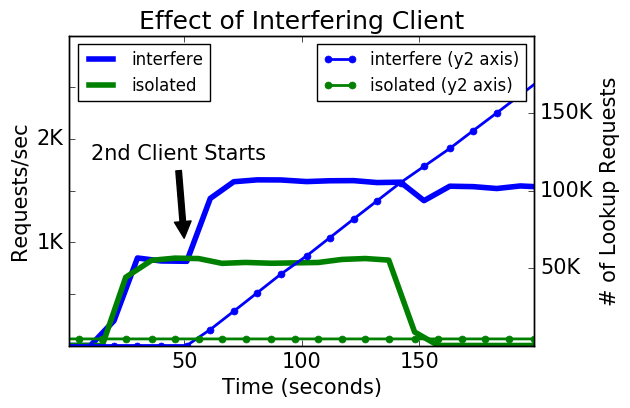

In [3]:
try:
    df  = pd.read_csv('../results-paper/nojournal-cache/tmp/handle_client_request_tput.wsp.out',
                     skiprows=13, names=["index", "time",'handle_client_request_tput'])
    df1 = pd.read_csv('../results-paper/nojournal-cache/tmp/req_lookup.wsp.out',
                     skiprows=13, names=["index", "time",'req_lookup'])
except:
    sys.exit("Please cd to experiments/baseline-interfere/results-paper/nojournal-cache & run ./plot.sh")    

font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()

# plot throughput
df = df[df['time'] != 0]                           # filter out null timestamps
init = float(df['time'].loc[0])                    # beginning of runs shifted to 0 (unix time stamp)
shft = df['index'].iloc[0]                         # shift timestamps to 0
df['x'] = df['time'] - init - shft                 # specify values for x axis
args = {'ax': ax, 'y': 'handle_client_request_tput', 'lw': 4}
df.plot(x='x', label='interfere', **args)          # plot interfere throughput
df.plot(x=df['x'] - 300, label='isolated', **args) # this is the same run, so shift 

# plot lookups
df1 = df1[df1['time'] != 0]                        # filter out null timestamps
shft = df1['index'].iloc[0]                        # shift timestamps to 0
df1['x'] = df1['time'] - init - shft               # specify values for x axis
args = {'ax': ax2, 'y': 'req_lookup', 'marker': '.', 'ms': 10, 'lw': 2}
df1.plot(x='x', label='interfere (y2 axis)', **args)
df1['req_lookup'] = df1['req_lookup'] - 210000     # this is the same run, shift total reqs
df1.plot(x=df1['x']-300, label='isolated (y2 axis)', **args)

# format
ax.set_title('Effect of Interfering Client')
ax.set_yticklabels(['', '', '1K', '', '2K', '', ''])
ax.set_ylim(0, 3000)
ax.set_ylabel('Requests/sec')
ax.set_xlabel('Time (seconds)')
ax.legend(loc='upper left', fontsize=12)
ax2.set_ylabel('# of Lookup Requests')
ax2.set_xlim(1, 199) 
ax2.set_ylim(1, 200000)
ax2.legend(loc='upper right', fontsize=12)
ax2.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in ax2.get_yticks()])
ax2.set_yticklabels(['', '50K', '100K', '150K', ''])

# add arrow
ax.annotate('2nd Client Starts', fontsize=15, xy=(50, 1000), xytext=(10, 1800),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='middle')
fig.savefig('../../../paper/graphs/behavior-interfere.png', bbox_inches='tight', dpi=400)